In [1]:
import tensorflow as tf
import pandas as pd
import torch
import random
import os

def read_tfrecord(example):
    df = pd.read_csv('preprocessed_data.csv')
    feature_description = {}
    for elem in list(df.columns)[1:]:
        feature_description[elem] = tf.io.FixedLenFeature([], tf.int64)
    feature_description['image'] = tf.io.FixedLenFeature([], tf.string)

    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, get_image_size())
    image = tf.cast(image, tf.float32) / 255.0
    
    label = []
    for val in list(df.columns)[1:]: 
        if val == "No Finding" or val == "Atelectasis" or val == "Infiltration" or val == "Effusion":
            label.append(example[val])

    return image, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    
    return dataset

def tensorflow_to_pytorch(dataset):
    set = []
    for _, data in enumerate(dataset):
        images, labels = data
        images = torch.from_numpy(images.numpy()).permute(2, 0, 1)
        labels = torch.from_numpy(labels.numpy())
        if labels.sum() != 0 and (not (labels.sum() == 1 and labels[0] == 1) or random.random() < 0.33): # filter data
            set.append([images, labels])
    return set

def get_datasets(sample=False):
    tfrlist = ['data/' + x for x in os.listdir('data')]
    file_names = tf.io.gfile.glob(tfrlist)

    all = list(range(len(file_names)))
    if sample:
        all = list(range(len(file_names))[:10])
    train_index = random.sample(all, int(len(all) * 0.7))
    test_and_validation_index = list(set(all) - set(train_index))
    valid_index = random.sample(test_and_validation_index, int(len(test_and_validation_index) * 0.5))
    text_index = list(set(test_and_validation_index) - set(valid_index))

    train_file_names, valid_file_names, test_file_names = [file_names[index] for index in train_index], [file_names[index] for index in valid_index], [file_names[index] for index in text_index]

    print("Converting training data.")
    train_dataset = tensorflow_to_pytorch(load_dataset(train_file_names))
    print("Training data converted.")

    print("Converting validation data.")
    valid_dataset = tensorflow_to_pytorch(load_dataset(valid_file_names))
    print("Validation data converted.")

    print("Converting test data.")
    test_dataset = tensorflow_to_pytorch(load_dataset(test_file_names))
    print("Test data converted.")

    return train_dataset, valid_dataset, test_dataset

In [2]:
import torch
import numpy as np

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for _, data in enumerate(data_loader):
        images, labels = data
        output = model(images)
        correct += torch.round(torch.sigmoid(output)).eq(labels).sum().item()
        total += labels.nelement()

    return correct / total

def get_loss(model, data_loader, criterion):
    total_loss = 0
    for i, data in enumerate(data_loader):
        images, labels = data
        output = model(images)
        loss = criterion(output, labels.type_as(output))
        total_loss += loss.item()
    return total_loss / (i+1)

def train(net, train_loader, valid_loader, criterion, optimizer, num_epochs):
    train_accuracy = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    epochs = range(num_epochs)

    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels.type_as(output))
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch: {epoch+1} Iteration: {i}\nTraining Loss: {get_loss(net, train_loader, criterion)}, Validation Loss: {get_loss(net, valid_loader, criterion)}, Training accuracy: {get_accuracy(net, train_loader)}, Validation accuracy: {get_accuracy(net, valid_loader)}")
        train_accuracy[epoch] = get_accuracy(net, train_loader)
        validation_accuracy[epoch] = get_accuracy(net, valid_loader)
        print(f"Epoch: {epoch+1}\nTraining Loss: {get_loss(net, train_loader, criterion)}, Validation Loss: {get_loss(net, valid_loader, criterion)}, Training accuracy: {train_accuracy[epoch]}, Validation accuracy: {validation_accuracy[epoch]}")

    print("Training complete.")

    return train_accuracy, validation_accuracy, epochs

In [3]:
def get_image_size():
    return image_size

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.layer1 = nn.Linear(100*100*3, 300)
        self.layer2 = nn.Linear(300, 64)
        self.layer3 = nn.Linear(64, 4)
    def forward(self, img):
        flattened = img.reshape(-1, 100*100*3)
        activation1 = self.layer1(flattened)
        activation1 = F.leaky_relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.leaky_relu(activation2)
        activation3 = self.layer3(activation2)
        
        return activation3
    
    
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size = 5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, kernel_size)
        self.conv3 = nn.Conv2d(3, 3, kernel_size)
        self.conv_to_fc = 1452
        self.fc1 = nn.Linear(self.conv_to_fc, 600)
        self.fc2 = nn.Linear(600, 32)
        self.fc3 = nn.Linear(32, 4)    

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(batch_size, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x =self.fc3(x)

        return x

In [5]:
batch_size = 64
num_epochs = 4
learning_rate = 0.001
image_size = [100, 100]

train_dataset, valid_dataset, test_dataset = get_datasets(sample=True)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)


Converting training data.
Training data converted.
Converting validation data.
Validation data converted.
Converting test data.
Test data converted.


Epoch: 1 Iteration: 0
Training Loss: 0.6812111813089122, Validation Loss: 0.6843959291776022, Training accuracy: 0.5084918478260869, Validation accuracy: 0.484375
Epoch: 1
Training Loss: 0.5920364778974782, Validation Loss: 0.584927499294281, Training accuracy: 0.709578804347826, Validation accuracy: 0.7122395833333334
Epoch: 2 Iteration: 0
Training Loss: 0.5914401904396389, Validation Loss: 0.5887765089670817, Training accuracy: 0.709578804347826, Validation accuracy: 0.7122395833333334
Epoch: 2
Training Loss: 0.5904166309729867, Validation Loss: 0.5835013190905253, Training accuracy: 0.7094089673913043, Validation accuracy: 0.7109375
Epoch: 3 Iteration: 0
Training Loss: 0.5909550811933435, Validation Loss: 0.5804680188496908, Training accuracy: 0.7097486413043478, Validation accuracy: 0.7161458333333334
Epoch: 3
Training Loss: 0.587301606717317, Validation Loss: 0.5876201391220093, Training accuracy: 0.7100883152173914, Validation accuracy: 0.7161458333333334
Epoch: 4 Iteration: 0
Tr

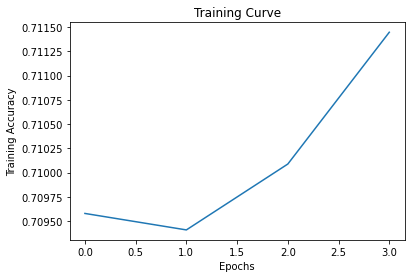

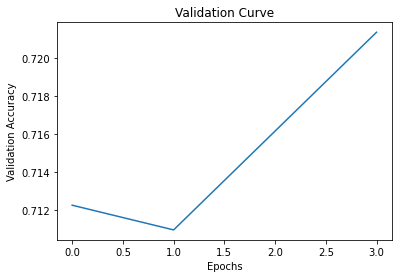

Test accuracy: 0.7122395833333334


In [6]:
net = SimpleCNN()
if torch.cuda.is_available():
    net.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)

train_accuracy, validation_accuracy, epochs = train(net, train_loader, valid_loader, criterion, optimizer, num_epochs)

plt.plot(epochs, train_accuracy)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, validation_accuracy)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

print(f"Test accuracy: {get_accuracy(net, test_loader)}")

Epoch: 1 Iteration: 0
Training Loss: 2.032762589661971, Validation Loss: 1.8951222101847331, Training accuracy: 0.7094089673913043, Validation accuracy: 0.7135416666666666
Epoch: 1
Training Loss: 0.6499348438304403, Validation Loss: 0.6182781855265299, Training accuracy: 0.7075407608695652, Validation accuracy: 0.7174479166666666
Epoch: 2 Iteration: 0
Training Loss: 0.6495556313058605, Validation Loss: 0.6253501574198405, Training accuracy: 0.7153532608695652, Validation accuracy: 0.7330729166666666
Epoch: 2
Training Loss: 0.5845624234365381, Validation Loss: 0.5581483244895935, Training accuracy: 0.7192595108695652, Validation accuracy: 0.7278645833333334
Epoch: 3 Iteration: 0
Training Loss: 0.5945484819619552, Validation Loss: 0.5799472332000732, Training accuracy: 0.71875, Validation accuracy: 0.7252604166666666
Epoch: 3
Training Loss: 0.6305215928865515, Validation Loss: 0.663057823975881, Training accuracy: 0.6351902173913043, Validation accuracy: 0.6106770833333334
Epoch: 4 Itera

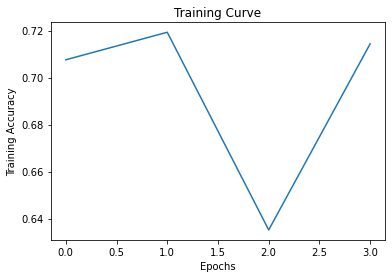

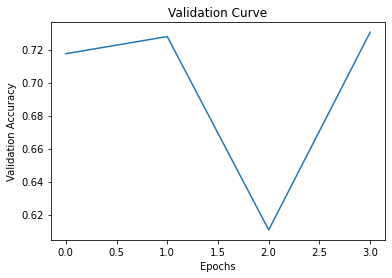

Test accuracy: 0.71484375


In [7]:
net = Baseline()
if torch.cuda.is_available():
    net.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)

train_accuracy, validation_accuracy, epochs = train(net, train_loader, valid_loader, criterion, optimizer, num_epochs)

plt.plot(epochs, train_accuracy)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, validation_accuracy)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

print(f"Test accuracy: {get_accuracy(net, test_loader)}")